In [3]:
from citalopram_project.load import load_neurons, load_spikes
from citalopram_project.ensemble.ensembles import (
    humphries_ensemble,
    communities_test,
    _create_ensemble_stats,
    _create_ensemble_df,
)
from citalopram_project.correlations import pairwise_correlation_spikes
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd


In [2]:
neurons = load_neurons()
spikes = load_spikes(block_name="base_shock").merge(
    neurons[["neuron_id", "session_name", "cluster"]]
)
baseline_spikes = spikes.loc[lambda x: x.spiketimes < 0].copy()
baseline_spikes.loc[:, "spiketimes"] = baseline_spikes.loc[:, "spiketimes"].add(600)
shock_spikes = spikes.loc[lambda x: x.spiketimes >= 0]


In [10]:
def find_ensembles(df_spikes, session_col="session_name"):
    stats_dfs = []
    ensembles_dfs = []
    for session in tqdm(df_spikes[session_col].unique()):
        df1 = df_spikes.loc[lambda x: x[session_col] == session]
        if len(df1) == 0:
            continue
        df_corr = pairwise_correlation_spikes(
            df1, bin_width=1, sigma=0, fillna=0, rectify=True
        )
        mod, communities, cluster_idx = humphries_ensemble(df_corr)
        if np.isnan(mod):
            continue
        com_scores, com_score_p_values, com_similarities = communities_test(
            df_corr, communities, n_boot=1000
        )
        stats_dfs.append(
            _create_ensemble_stats(
                mod, communities, com_scores, com_score_p_values, com_similarities
            ).assign(session_name=session)
        )
        ensembles_dfs.append(
            _create_ensemble_df(communities).assign(session_name=session)
        )
    return pd.concat(ensembles_dfs), pd.concat(stats_dfs)


In [11]:
from citalopram_project.ensemble.ensembles import (
    get_ensemble_sig,
    get_ensemble_id,
    drop_non_sig_ensembles,
)


ensembledf_baseline, statsdf_baseline = find_ensembles(baseline_spikes)

statsdf_baseline = get_ensemble_sig(statsdf_baseline)
statsdf_baseline, ensembledf_baseline = get_ensemble_id(statsdf_baseline, ensembledf_baseline)
ensembledf_baseline = drop_non_sig_ensembles(statsdf_baseline, ensembledf_baseline)


  0%|          | 0/9 [00:00<?, ?it/s]

In [14]:
ensembledf_shock, statsdf_shock = find_ensembles(shock_spikes)

statsdf_shock = get_ensemble_sig(statsdf_shock)
statsdf_shock, ensembledf_shock = get_ensemble_id(statsdf_shock, ensembledf_shock)
ensembledf_shock = drop_non_sig_ensembles(statsdf_shock, ensembledf_shock)


  0%|          | 0/9 [00:00<?, ?it/s]

In [57]:
ensembledf_baseline.to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseline_shock_ensembles.csv")
ensembledf_shock.to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\shock_shock_ensembles.csv")

In [114]:
stats = pd.concat((statsdf_shock.assign(block="shock"), statsdf_baseline.assign(block="baseline"))).merge(load_neurons()[["session_name", "group"]].drop_duplicates())

stats.to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseline_and_evoked_ensemble_stats.csv")

# Evoked ensembles analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


stats = pd.read_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseline_and_evoked_ensemble_stats.csv")
ensembledf_baseline = pd.read_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseline_shock_ensembles.csv")
ensembledf_shock = pd.read_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\shock_shock_ensembles.csv")

shock_sessions = load_spikes("base_shock").merge(load_neurons()[["session_name", "neuron_id"]]).session_name.unique()

baseline_neurons = (
    load_neurons()[["neuron_id", "session_name", "group"]]
    .loc[lambda x: x.session_name.isin(shock_sessions)]
    .merge(ensembledf_baseline, how="left")
    .assign(in_ensemble=lambda x: ~x.ensemble_id.isnull())
    .assign(block="baseline")
)

shock_neurons = (
    load_neurons()[["neuron_id", "session_name", "group"]]
    .loc[lambda x: x.session_name.isin(shock_sessions)]
    .merge(ensembledf_shock, how="left")
    .assign(in_ensemble=lambda x: ~x.ensemble_id.isnull())
    .assign(block="shock")
)

ensemble_neurons = pd.concat([baseline_neurons, shock_neurons])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            simmilarity   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.158
Method:                 Least Squares   F-statistic:                    0.1376
Date:                Tue, 11 Jan 2022   Prob (F-statistic):              0.936
Time:                        07:57:37   Log-Likelihood:                 26.591
No. Observations:                  20   AIC:                            -45.18
Df Residuals:                      16   BIC:                            -41.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.2230      0.032      6.966      0.000       0.155       0.291
group[T.sal]                   -0.0140      0.042     -0.334      0.743      -0.103       0.075
block[T.shock]                  0.0093      0.045      0.204      0.841      -0.087       0.105
group[T.sal]:block[T.shock]    -0.0119      0.067     -0.178      0.861      -0.154       0.130
==============================================================================
Omnibus:                        0.692   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.513
Skew:                           0.362   Prob(JB):                        0.774
Kurtosis:                       2.700   Cond. No.                         6.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

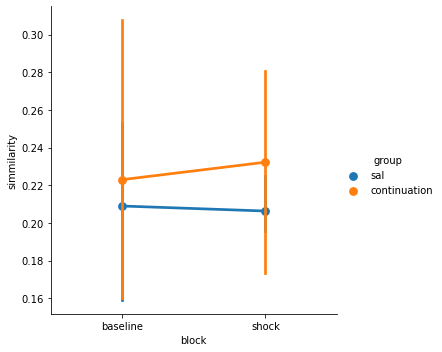

In [14]:
# similarity change between blocks, by group

sns.catplot(data=stats.loc[lambda x: x.ensemble_sig], y="simmilarity", x="block", hue="group", kind="point")
plt.savefig("ensemble_sim_change.svg")

model = smf.ols("simmilarity ~ group * block", data=stats.loc[lambda x: x.ensemble_sig]).fit()
res = model.summary()
res

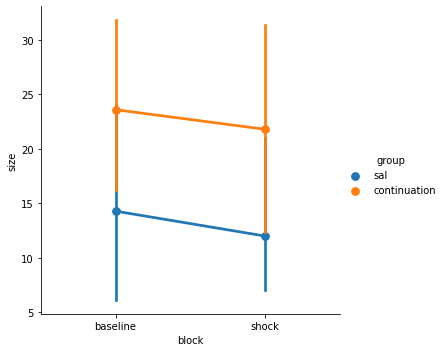

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.054
Date:                Tue, 11 Jan 2022   Prob (F-statistic):              0.396
Time:                        07:58:54   Log-Likelihood:                -75.345
No. Observations:                  20   AIC:                             158.7
Df Residuals:                      16   BIC:                             162.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [17]:
sns.catplot(data=stats.loc[lambda x: x.ensemble_sig], y="size", x="block", hue="group", kind="point")
plt.show()

model = smf.ols("size ~ group * block", data=stats.loc[lambda x: x.ensemble_sig]).fit()
res = model.summary()
print(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Generalized Linear Model Regression Results                              
=======================================================================================================
Dep. Variable:     ['in_ensemble[False]', 'in_ensemble[True]']   No. Observations:                  546
Model:                                                     GLM   Df Residuals:                      542
Model Family:                                         Binomial   Df Model:                            3
Link Function:                                           logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -303.05
Date:                                         Tue, 11 Jan 2022   Deviance:                       606.11
Time:                                                 08:15:01   Pearson chi2:                     546.
No. Iterations:                                              4                                         
Covariance Type:                                     nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -1.8326      0.269     -6.806      0.000      -2.360      -1.305
group[T.continuation]                    0.7255      0.327      2.222      0.026       0.085       1.365
block[T.shock]                           2.6311      0.336      7.835      0.000       1.973       3.289
group[T.continuation]:block[T.shock]    -2.3441      0.421     -5.573      0.000      -3.168      -1.520
========================================================================================================
"""

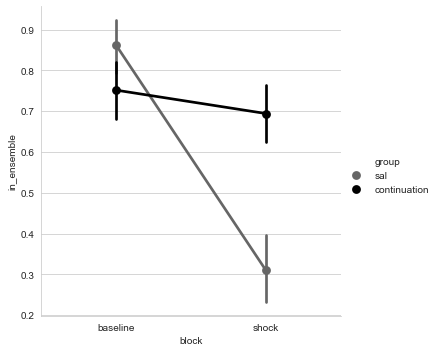

In [43]:
# proportion of units in ensembles

colors = ["#000000", "#666666"][::-1]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

# sns.pa
sns.catplot(data=ensemble_neurons, y="in_ensemble", x="block", hue="group", kind="point")
plt.savefig("Ensemble PCT change.svg")

model = smf.glm("in_ensemble ~ group * block", family=sm.families.Binomial(), data=ensemble_neurons).fit()
res = model.summary()
res

In [33]:
# proportion of SR units in ensembles


# df_sr = ensemble_neurons.merge(load_neurons()[["neuron_id", "cluster"]], how="left").loc[lambda x: x.cluster == "slow_regular"]

# sns.catplot(data=df_sr, y="in_ensemble", x="block", hue="group", kind="point")
# # plt.savefig("Ensemble PCT change.svg")

# model = smf.glm("in_ensemble ~ group * block", family=sm.families.Binomial(), data=df_sr).fit()
# res = model.summary()
# res


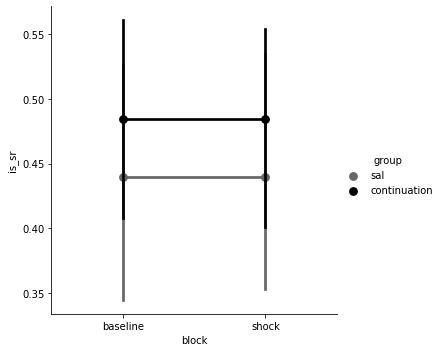

In [42]:
# proportion of ensemble units which are SR

df_clusters = ensemble_neurons.merge(load_neurons()[["neuron_id", "cluster"]], how="left")
df_clusters["is_sr"] = df_clusters["cluster"] == "slow_regular"

sns.catplot(data=df_clusters, y="is_sr", x="block", hue="group", kind="point")


In [175]:
# overlap


def get_session_sensembles(session_name, df_all_neurons, df_ensembles):
    ensembles = df_ensembles.loc[lambda x: x.session_name == session_name].ensemble_id.unique()
    all_neurons = df_all_neurons.loc[lambda x: x.session_name == session_name].neuron_id.unique()
    out = {}
    for ensemble in ensembles:
        ensemble_neurons = df_ensembles.loc[lambda x: x.ensemble_id == ensemble].neuron_id.values
        out[ensemble] = np.where(np.in1d(all_neurons, ensemble_neurons), 1, 0)
    return out


def overlap_responders(x: np.ndarray, y: np.ndarray):
    return np.mean(y[x==1]) - np.mean(y)

def overlap_both(x: np.ndarray, y: np.ndarray):
    return np.mean((x + y) == 2)

def overlap_same(x: np.ndarray, y: np.ndarray):
    return np.mean(x == y)

def get_p(obs, reps):
    return np.mean(reps >= obs)

def is_same(x, y, f, n_boot=1000):
    observed = f(x, y)
    reps = ez.bs_2sample(x, y, f, size=n_boot)
    p = get_p(observed, reps)
    return observed, p


def overlap_new(a, b):
    # prop of b's entries that are in a
    prop_b = np.mean(b[a == 1])

    # prop of a's entries that are in b
    prop_a = np.mean(a[b == 1])
    return np.min([prop_b, prop_a])



In [176]:
import ezbootstrap as ez

def find_overlap(df_ensembles_base, df_ensembles_shock, n_boot=1000):
    out = []
    for session_name in shock_sessions:
        spont_neurons = get_session_sensembles(session_name, df_ensembles_base, df_ensembles_base.dropna())
        shock_neurons = get_session_sensembles(session_name, df_ensembles_shock, df_ensembles_shock.dropna())
        for spont_ensemble_name, spont_ensemble in spont_neurons.items():
            for shock_ensemble_name, shock_ensemble in shock_neurons.items():
                obs, p = is_same(spont_ensemble, shock_ensemble, overlap_new, n_boot=n_boot)
                out.append(
                    {"session_name": session_name, 
                    "spont_ensemble": spont_ensemble_name,
                    "shock_ensemble": shock_ensemble_name,
                    "spont_size": np.sum(spont_ensemble),
                    "shock_size":  np.sum(shock_ensemble),
                    "overlap": obs,
                    "p": p})
    return pd.DataFrame(out)

In [177]:
sal_ensembles_base = ensemble_neurons.loc[lambda x: (x.group == "sal") & (x.block == "baseline")]
sal_ensembles_shock = ensemble_neurons.loc[lambda x: (x.group == "sal") & (x.block == "shock")]
cit_ensembles_base = ensemble_neurons.loc[lambda x: (x.group == "continuation") & (x.block == "baseline")]
cit_ensembles_shock = ensemble_neurons.loc[lambda x: (x.group == "continuation") & (x.block == "shock")]


df_overlap = pd.concat([find_overlap(sal_ensembles_base, sal_ensembles_shock), find_overlap(cit_ensembles_base, cit_ensembles_shock)])

C:\Users\roryl\.conda\envs\ephys\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\ephys\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\ephys\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\ephys\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\ephys\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Num

In [181]:
df_overlap

,session_name,spont_ensemble,shock_ensemble,spont_size,shock_size,overlap,p,group
0,hamilton_13,3.0,3.0,8,7,0.750000,0.000,sal
1,hamilton_07,6.0,8.0,31,8,0.096774,1.000,sal
2,hamilton_07,7.0,8.0,14,8,0.357143,0.000,sal
3,hamilton_19,10.0,13.0,35,21,0.600000,0.000,sal
4,hamilton_19,11.0,13.0,5,21,0.000000,1.000,sal
5,hamilton_19,12.0,13.0,4,21,0.000000,1.000,sal
6,hamilton_23,4.0,5.0,39,38,0.538462,1.000,continuation
7,hamilton_23,4.0,6.0,39,19,0.461538,0.000,continuation
8,hamilton_23,5.0,5.0,18,38,0.447368,0.000,continuation
9,hamilton_23,5.0,6.0,18,19,0.052632,1.000,continuation


In [186]:
overlap_res.assign(overlap_min =lambda x: (x.has_overlap) & (x.overlap >=0.5))

,ensemble_id,group_x,session_name_x,has_overlap,session_name_y,spont_ensemble,shock_ensemble,spont_size,shock_size,overlap,p,group_y,overlap_min
0,3,sal,hamilton_13,True,hamilton_13,3.0,3.0,8,7,0.750000,0.000,sal,True
1,4,continuation,hamilton_23,True,hamilton_23,4.0,5.0,39,38,0.538462,1.000,continuation,True
2,4,continuation,hamilton_23,True,hamilton_23,4.0,6.0,39,19,0.461538,0.000,continuation,False
3,5,continuation,hamilton_23,True,hamilton_23,5.0,5.0,18,38,0.447368,0.000,continuation,False
4,5,continuation,hamilton_23,True,hamilton_23,5.0,6.0,18,19,0.052632,1.000,continuation,False
5,6,sal,hamilton_07,False,hamilton_07,6.0,8.0,31,8,0.096774,1.000,sal,False
6,7,sal,hamilton_07,True,hamilton_07,7.0,8.0,14,8,0.357143,0.000,sal,False
7,8,continuation,hamilton_08,True,hamilton_08,8.0,9.0,13,26,0.153846,1.000,continuation,False
8,8,continuation,hamilton_08,True,hamilton_08,8.0,11.0,13,5,0.230769,0.000,continuation,False
9,9,continuation,hamilton_08,True,hamilton_08,9.0,9.0,29,26,0.758621,0.000,continuation,True


In [211]:
df_overlap = df_overlap.merge(load_neurons()[["group", "session_name"]].drop_duplicates())

overlap_res = (
    stats.loc[lambda x: x.block == "baseline"][["ensemble_id", "ensemble_sig"]]
    .loc[lambda x: (x.ensemble_sig)]
    .merge(df_overlap, how="left", left_on="ensemble_id",right_on="spont_ensemble")
    .assign(significant_overlap = lambda x: (x["p"] < 0.05) & x["overlap"] >= 0.5)
    # .groupby(["ensemble_id", "group", "session_name"], as_index=False)
    # .apply(lambda x: (x["p"] < 0.05 & x[""]).any() )
    # .rename(columns={None: "has_overlap"})
    # .merge(df_overlap.drop(["group", "session_name"], axis=1), how="left", left_on="ensemble_id",right_on="spont_ensemble")
    # .assign(overlap_min =lambda x: (x.has_overlap) & (x.overlap >=0.5))
)

In [218]:
by_sessions = overlap_res.groupby(["ensemble_id", "group", "session_name"], as_index=False).apply(lambda x: x["significant_overlap"].any() )
by_sessions.rename(columns={None: "has_overlap"}, inplace=True)

# sns.barplot(data=by_sessions, y="significant_overlap", x="group")
# plt.savefig("Ensemble PCT change.svg")

# model = smf.glm("has_overlap ~ group", family=sm.families.Binomial(), data=overlap_res).fit()
# res = model.summary()
# res
# plt.savefig("Prop overlap.svg")

,ensemble_id,group,session_name,has_overlap
0,3,sal,hamilton_13,True
1,4,continuation,hamilton_23,True
2,5,continuation,hamilton_23,True
3,6,sal,hamilton_07,False
4,7,sal,hamilton_07,True
5,8,continuation,hamilton_08,True
6,9,continuation,hamilton_08,True
7,10,sal,hamilton_19,True
8,11,sal,hamilton_19,False
9,12,sal,hamilton_19,False


<AxesSubplot:xlabel='group', ylabel='overlap'>

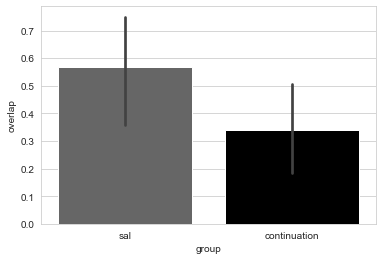

In [200]:
sns.barplot(data=overlap_res.loc[lambda x: x.has_overlap], y="overlap", x="group")

In [201]:
overlap_res.loc[lambda x: x.has_overlap]

,ensemble_id,group,session_name,has_overlap,spont_ensemble,shock_ensemble,spont_size,shock_size,overlap,p,overlap_min
0,3,sal,hamilton_13,True,3.0,3.0,8,7,0.750000,0.0,True
1,4,continuation,hamilton_23,True,4.0,5.0,39,38,0.538462,1.0,True
2,4,continuation,hamilton_23,True,4.0,6.0,39,19,0.461538,0.0,False
3,5,continuation,hamilton_23,True,5.0,5.0,18,38,0.447368,0.0,False
4,5,continuation,hamilton_23,True,5.0,6.0,18,19,0.052632,1.0,False
6,7,sal,hamilton_07,True,7.0,8.0,14,8,0.357143,0.0,False
7,8,continuation,hamilton_08,True,8.0,9.0,13,26,0.153846,1.0,False
8,8,continuation,hamilton_08,True,8.0,11.0,13,5,0.230769,0.0,False
9,9,continuation,hamilton_08,True,9.0,9.0,29,26,0.758621,0.0,True
10,9,continuation,hamilton_08,True,9.0,11.0,29,5,0.068966,1.0,False


# Example Heatmaps

In [45]:
# example ensemble

from citalopram_project.load import load_spikes
from citalopram_project.correlations import pairwise_correlation_spikes
import numpy as np 

def _reindex(df: pd.DataFrame, idx: np.ndarray) -> pd.DataFrame:
    idx = idx[np.isin(idx, df.columns)]
    df = df.reindex(idx)
    df = df[idx]
    return df

def get_index(df: pd.DataFrame, all_neurons: np.ndarray):
    ensemble_list = [
        df[df["ensemble_id"] == ensemble_name].neuron_id.unique()
        for ensemble_name in df.ensemble_id.unique().tolist()
    ]
    ensemble_neurons = np.concatenate(ensemble_list)
    non_ensemble_neurons = [n for n in all_neurons if n not in ensemble_neurons.tolist()]
    index = np.concatenate([ensemble_neurons, non_ensemble_neurons])
    return index

def plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1):
    df_corr = pairwise_correlation_spikes(df_spikes = df_spikes.loc[lambda x: x.session_name == session_name],
        bin_width = bin_width,
        rectify=True,
        fillna=True)
    idx = get_index(
        df_ensembles.loc[lambda x: x.session_name == session_name], 
        all_neurons.loc[lambda x: x.session_name == session_name]["neuron_id"].unique()
        )
    df_corr = _reindex(df_corr, idx)
    return sns.heatmap(df_corr, vmin=0, vmax=1, cmap="Greys")


In [76]:
sal_sessions = load_neurons().loc[lambda x: x.group == "sal"]["session_name"].unique()
cit_sessions = load_neurons().loc[lambda x: x.group == "continuation"]["session_name"].unique()

df_spikes = (
    load_spikes("base_shock")
    .merge(load_neurons()[["neuron_id", "session_name"]])
)

df_spikes_base = df_spikes.loc[lambda x: x.spiketimes < 0].assign(spiketimes=lambda x: x.spiketimes.add(600))
df_spikes_shock = df_spikes.loc[lambda x: x.spiketimes >= 0]

base_ensembles = ensemble_neurons.dropna()[["neuron_id", "ensemble_id", "block", "session_name"]].loc[lambda x: x.block == "baseline"]
shock_ensembles = ensemble_neurons.dropna()[["neuron_id", "ensemble_id", "block", "session_name"]].loc[lambda x: x.block == "shock"]


all_neurons = load_neurons()[["neuron_id", "session_name", "group"]]

hamilton_07


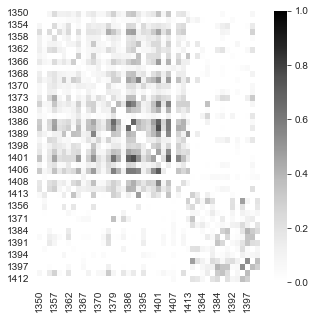

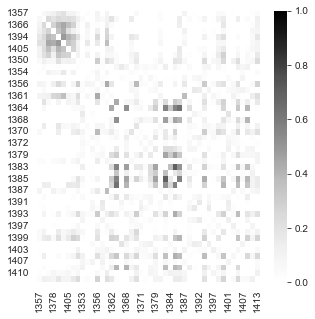

In [121]:
sal_session_name = sal_sessions[2]
plt.figure(figsize=(5, 5))
plot_heatmap(sal_session_name, df_spikes_base, base_ensembles, all_neurons, bin_width=1)
plt.savefig("sal ensemble baseline.png", dpi=300)

plt.figure(figsize=(5, 5))
plot_heatmap(sal_session_name, df_spikes_shock, shock_ensembles, all_neurons, bin_width=1)
plt.savefig("sal ensemble shock.png", dpi=300)

print(sal_session_name)

hamilton_23


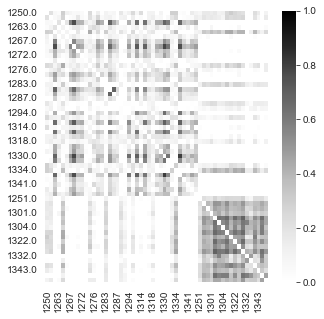

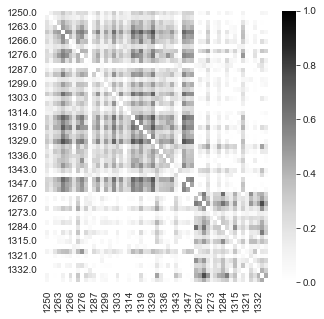

In [141]:
cit_session_name = cit_sessions[2]
plt.figure(figsize=(5, 5))
plot_heatmap(cit_session_name, df_spikes_base, base_ensembles, all_neurons, bin_width=1)
plt.savefig("cit ensemble baseline.png", dpi=300)


plt.figure(figsize=(5, 5))
plot_heatmap(cit_session_name, df_spikes_shock, shock_ensembles, all_neurons, bin_width=1)
plt.savefig("cit ensemble shock.png", dpi=300)
print(cit_session_name)

In [137]:
to_sanky = (
    ensemble_neurons
    .loc[lambda x: x.session_name == sal_session_name]
    .pivot(index="neuron_id", columns="block", values="ensemble_id")
    .fillna("None")
    .assign(transition=lambda x: x.baseline.astype(str) + "_" + x.shock.astype(str))
)
print("Baseline")
print(to_sanky["baseline"].value_counts())
print("")

print("Shock")
print(to_sanky["shock"].value_counts())
print("")

print("Transition")
print(to_sanky["transition"].value_counts())
print("")

Baseline
6.0     31
7.0     14
None     1
Name: baseline, dtype: int64

Shock
None    38
8.0      8
Name: shock, dtype: int64

Transition
6.0_None     28
7.0_None      9
7.0_8.0       5
6.0_8.0       3
None_None     1
Name: transition, dtype: int64



In [144]:
to_sanky = (
    ensemble_neurons
    .loc[lambda x: x.session_name == cit_session_name]
    .pivot(index="neuron_id", columns="block", values="ensemble_id")
    .fillna("None")
    .assign(transition=lambda x: x.baseline.astype(str) + "_" + x.shock.astype(str))
)
print("Baseline")
print(to_sanky["baseline"].value_counts())
print("")

print("Shock")
print(to_sanky["shock"].value_counts())
print("")

print("Transition")
print(to_sanky["transition"].value_counts())
print("")

Baseline
4.0    39
5.0    18
Name: baseline, dtype: int64

Shock
5.0    38
6.0    19
Name: shock, dtype: int64

Transition
4.0_5.0    21
4.0_6.0    18
5.0_5.0    17
5.0_6.0     1
Name: transition, dtype: int64



In [148]:
overlap_res.loc[lambda x: x.session_name == cit_session_name]

,ensemble_id,group,session_name,has_overlap
1,4,continuation,hamilton_23,True
2,5,continuation,hamilton_23,True


In [151]:
df_overlap.loc[lambda x: x.spont_ensemble == 5]

,session_name,spont_ensemble,shock_ensemble,spont_size,shock_size,overlap,p,group
8,hamilton_23,5.0,5.0,18,38,0.277778,0.0,continuation
9,hamilton_23,5.0,6.0,18,19,-0.277778,1.0,continuation


In [139]:
df_overlap.loc[lambda x: x.session_name == sal_session_name]

,session_name,spont_ensemble,shock_ensemble,spont_size,shock_size,overlap,p,group
1,hamilton_07,6.0,8.0,31,8,-0.077139,1.0,sal
2,hamilton_07,7.0,8.0,14,8,0.183230,0.0,sal


In [ ]:
(
    ensemble_neurons
    .groupby(["neuron_id", "block"])
    .apply(lambda x: pd.Series("baseline_ensemble": x.loc[lambda x: x.block]))loc[lambda x: (x.session_name == sal_session_name) & (x.block == "baseline")]

In [ ]:
def overlap_new(a, b):
    # prop of b's entries that are in a
    prop_b = np.mean(b[a] == 1)

    # prop of a's entries that are in b
    prop_a = np.mean(a[b] == 1)
    return np.mean([prop_b, prop_a])


In [109]:
overlap_res

,ensemble_id,group,session_name,has_overlap
0,3,sal,hamilton_13,True
1,4,continuation,hamilton_23,True
2,5,continuation,hamilton_23,True
3,6,sal,hamilton_07,False
4,7,sal,hamilton_07,True
5,8,continuation,hamilton_08,True
6,9,continuation,hamilton_08,True
7,10,sal,hamilton_19,True
8,11,sal,hamilton_19,False
9,12,sal,hamilton_19,False
